In [2]:
from pysmiles import read_smiles
import networkx as nx
import pandas
import pubchempy as pcp
from tqdm import tqdm

In [2]:

smiles = "C12=C3C4=C5C6=C1C7=C8C9=C1C%10=C%11C(=C29)C3=C2C3=C4C4=C5C5=C9C6=C7C6=C7C8=C1C1=C8C%10=C%10C%11=C2C2=C3C3=C4C4=C5C5=C%11C%12=C(C6=C95)C7=C1C1=C%12C5=C%11C4=C3C3=C5C(=C81)C%10=C23"
mol = read_smiles(smiles)

# atom vector (C only)
print(mol.nodes(data="element"))
# adjacency matrix
print(nx.to_numpy_matrix(mol))


[(0, 'C'), (1, 'C'), (2, 'C'), (3, 'C'), (4, 'C'), (5, 'C'), (6, 'C'), (7, 'C'), (8, 'C'), (9, 'C'), (10, 'C'), (11, 'C'), (12, 'C'), (13, 'C'), (14, 'C'), (15, 'C'), (16, 'C'), (17, 'C'), (18, 'C'), (19, 'C'), (20, 'C'), (21, 'C'), (22, 'C'), (23, 'C'), (24, 'C'), (25, 'C'), (26, 'C'), (27, 'C'), (28, 'C'), (29, 'C'), (30, 'C'), (31, 'C'), (32, 'C'), (33, 'C'), (34, 'C'), (35, 'C'), (36, 'C'), (37, 'C'), (38, 'C'), (39, 'C'), (40, 'C'), (41, 'C'), (42, 'C'), (43, 'C'), (44, 'C'), (45, 'C'), (46, 'C'), (47, 'C'), (48, 'C'), (49, 'C'), (50, 'C'), (51, 'C'), (52, 'C'), (53, 'C'), (54, 'C'), (55, 'C'), (56, 'C'), (57, 'C'), (58, 'C'), (59, 'C')]
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


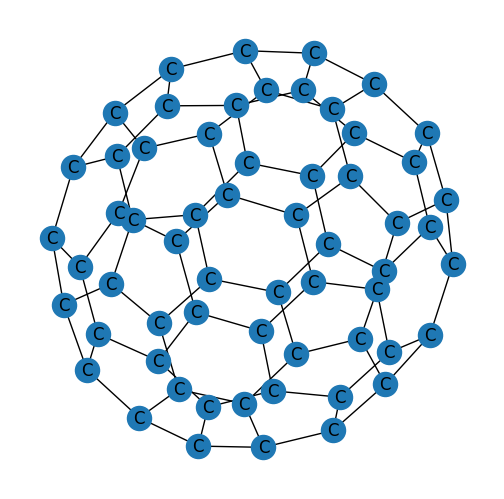

In [3]:
import matplotlib.pyplot as plt
elements = nx.get_node_attributes(mol, name = "element")
nx.draw(mol, with_labels=True, labels = elements, pos=nx.spring_layout(mol))
plt.gca().set_aspect('equal')

In [4]:
def stitch_flat_to_pubchem(cid):
    assert cid.startswith('CID')
    return int(cid[3:]) - 1e8

def stitch_stereo_to_pubchem(cid):
    assert cid.startswith('CID')
    return int(cid[3:])

In [5]:
# Read DrugBank terms
url = 'https://raw.githubusercontent.com/dhimmel/drugbank/3e87872db5fca5ac427ce27464ab945c0ceb4ec6/data/drugbank.tsv'
drugbank_df = pandas.read_table(url)[['drugbank_id', 'name']].rename(columns={'name': 'drugbank_name'})

# Pubchem to DrugBank mapping
url = 'https://raw.githubusercontent.com/dhimmel/drugbank/3e87872db5fca5ac427ce27464ab945c0ceb4ec6/data/mapping/pubchem.tsv'
drugbank_map_df = pandas.read_table(url)

In [6]:
# Load Sider names
sider_names = pandas.read_table('./data/drug_names.tsv', header=None, names=['cid', 'name'])

In [7]:
sider_names['cid'].replace('CID\d', '', regex=True, inplace=True)
sider_names['cid'] = sider_names['cid'].astype(int)

In [8]:
sider_smiles = []

for i, row in tqdm(sider_names.iterrows(), total=len(sider_names)):
    try:
        compound = pcp.Compound.from_cid(row["cid"])
        sider_smiles.append(
            {"cid": row["cid"], "name": row["name"], "smiles": compound.isomeric_smiles},
        )
    except:
        print("Error: ", row["cid"], row["name"])
        pass


100%|██████████| 1430/1430 [24:48<00:00,  1.04s/it]


In [9]:
sider_smiles_df = pandas.DataFrame(sider_smiles)
sider_smiles_df.to_csv("./data/sider_smiles.csv", index=False)